In [100]:
from gibbs.preparation.varqite import pauli_rotations_ansatz
import numpy as np
from dualtime.src.mclachlan import VarQITE
from gibbs.utils import create_hamiltonian_lattice,printarray,expected_state,state_from_ansatz, identity_purification, conjugate_pauli
from gibbs.preparation.varqite import efficient_su2_ansatz,brute_force_optimization, efficient_su2_ansatz_V3
from gibbs.preparation.free_energy import brute_cmaes
from qiskit.opflow import PauliSumOp
from qiskit.quantum_info import SparsePauliOp,Pauli,partial_trace,Statevector
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of gibbs.preparation.varqite failed: Traceback (most recent call last):
  File "/home/drudis/python_environements/JulienVarQITE/lib64/python3.10/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/home/drudis/python_environements/JulienVarQITE/lib64/python3.10/site-packages/IPython/extensions/autoreload.py", line 459, in superreload
    module = reload(module)
  File "/usr/lib64/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/drudis/GH/Julien/gibbs_code/gibbs/preparation/varqite.py", line 93
    

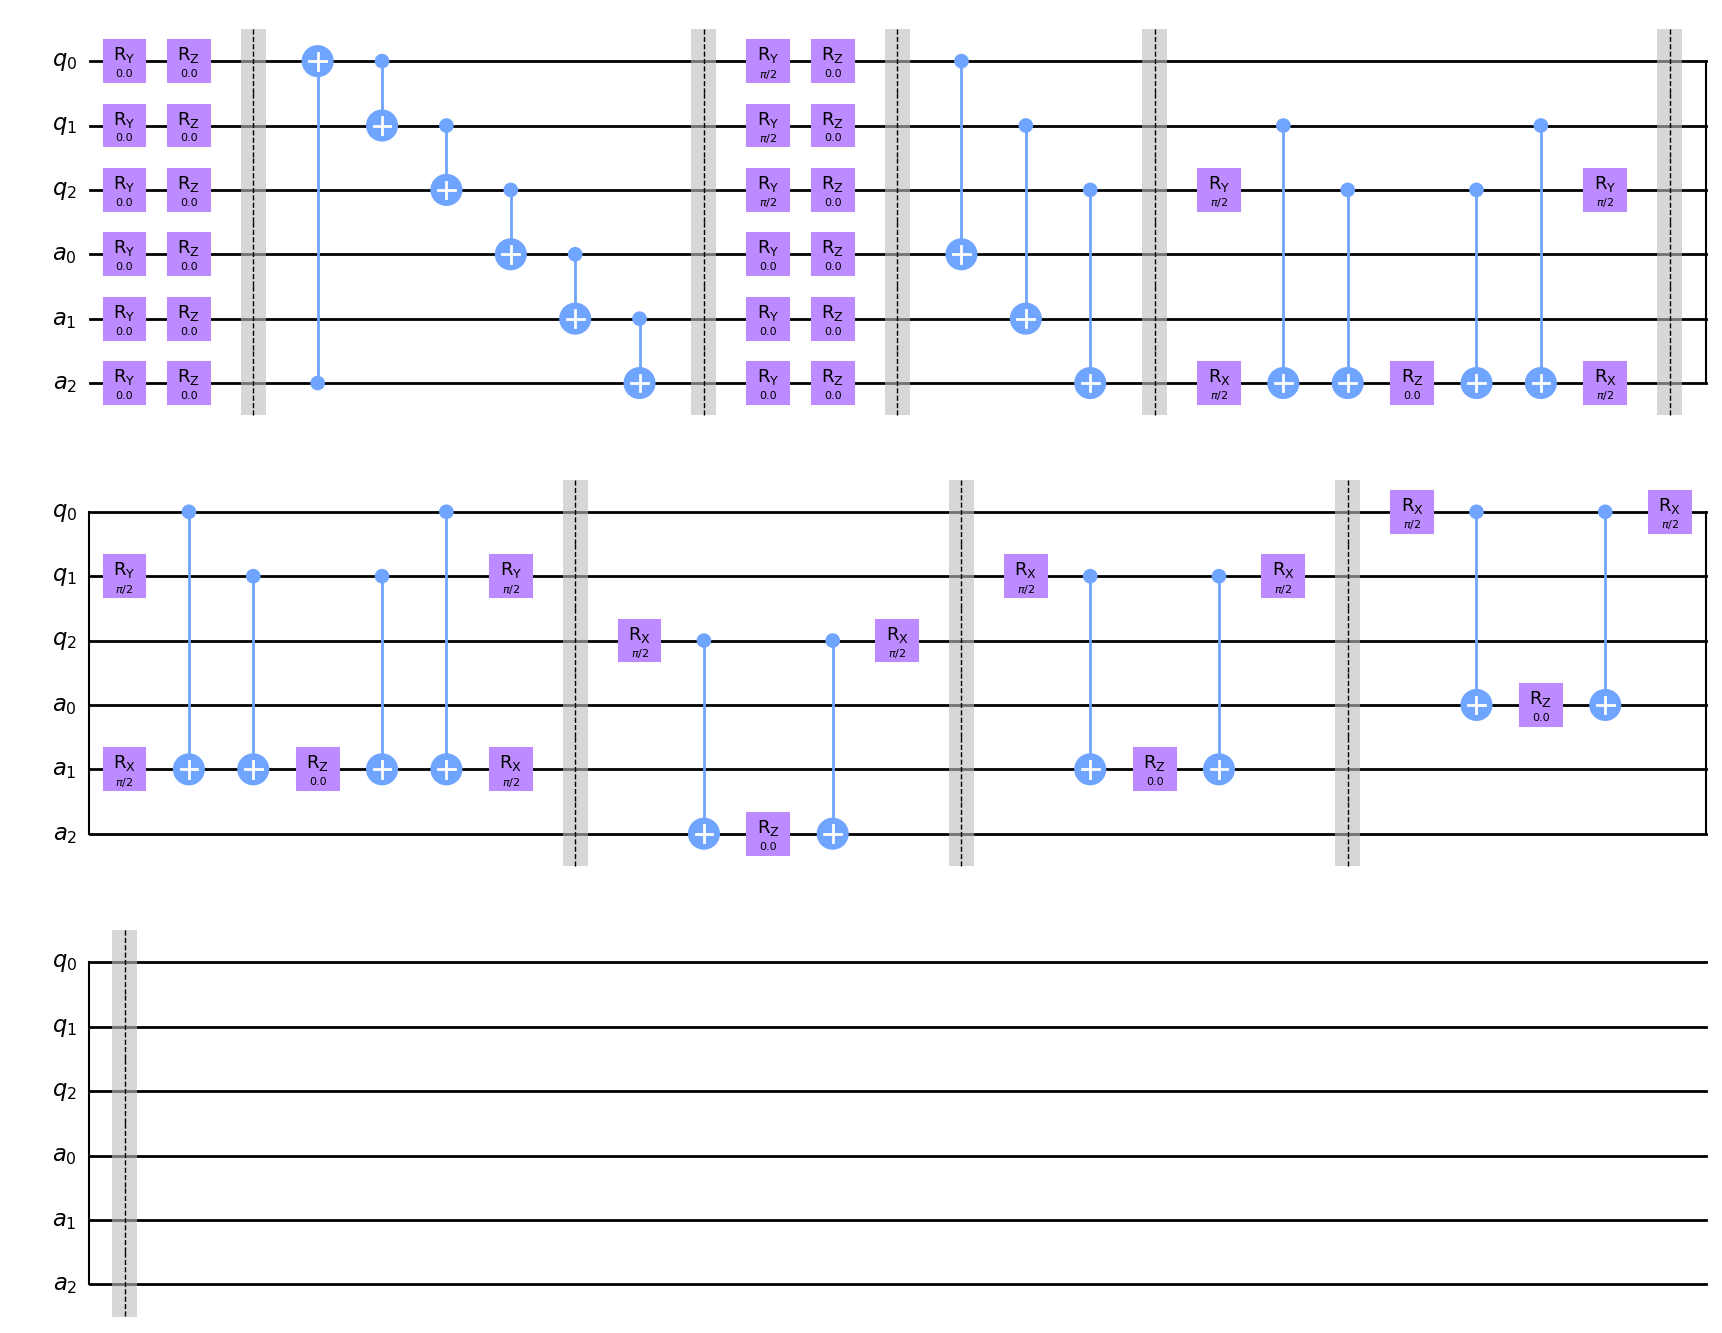

DensityMatrix([[0.125+0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j,
                0.   +0.j, 0.   +0.j, 0.   +0.j],
               [0.   +0.j, 0.125+0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j,
                0.   +0.j, 0.   +0.j, 0.   +0.j],
               [0.   +0.j, 0.   +0.j, 0.125+0.j, 0.   +0.j, 0.   +0.j,
                0.   +0.j, 0.   +0.j, 0.   +0.j],
               [0.   +0.j, 0.   +0.j, 0.   +0.j, 0.125+0.j, 0.   +0.j,
                0.   +0.j, 0.   +0.j, 0.   +0.j],
               [0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j, 0.125+0.j,
                0.   +0.j, 0.   +0.j, 0.   +0.j],
               [0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j,
                0.125+0.j, 0.   +0.j, 0.   +0.j],
               [0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j,
                0.   +0.j, 0.125+0.j, 0.   +0.j],
               [0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j,
                0.   +0.j, 0.   +0.j, 0.125+0.j]],
              dims=(2, 2, 2))


In [118]:
beta = 0.1
hamiltonian = create_hamiltonian_lattice(3,1.3,1.7)
# pauli_string = "XY"
# conj_pauli = conjugate_pauli(pauli_string)
# print(f"The conjugate of {pauli_string} is {conj_pauli}")
# hamiltonian = SparsePauliOp.from_list([(pauli_string,1)])
N = hamiltonian.num_qubits
rotations = [Pauli("ZIYY")]
ansatz,x0 = pauli_rotations_ansatz(hamiltonian,depth=1)
display(ansatz.decompose().bind_parameters(x0).draw(output="mpl"))
print(state_from_ansatz(ansatz,x0))

In [96]:
from surfer.gradient import ReverseGradient
gradient = ReverseGradient(partial_gradient=True,do_checks=False)
print(np.linalg.norm(gradient.compute(hamiltonian^("I"*N), ansatz, x0)))
op = SparsePauliOp(rotations[0])
prod = op@(hamiltonian^("I"*N))
print(identity_purification(N).expectation_value(op@(hamiltonian^("I"*N))))

0.49999999999999906
1j


In [31]:
from qiskit.circuit import Parameter
a= Parameter("a")
expression = a*7
list(expression.parameters)[0]

Parameter(a)

In [58]:
print(ansatz.decompose().data[11].operation)
from qiskit.circuit.library import RZGate
RZGate(a)
new_ansatz = ansatz.decompose()
new_ansatz.data[11].operation = RZGate(a)
print(new_ansatz.decompose().data[11].operation)


Instruction(name='rz', num_qubits=1, num_clbits=0, params=[ParameterExpression(1.0*theta)])
Instruction(name='u1', num_qubits=1, num_clbits=0, params=[Parameter(a)])


theta


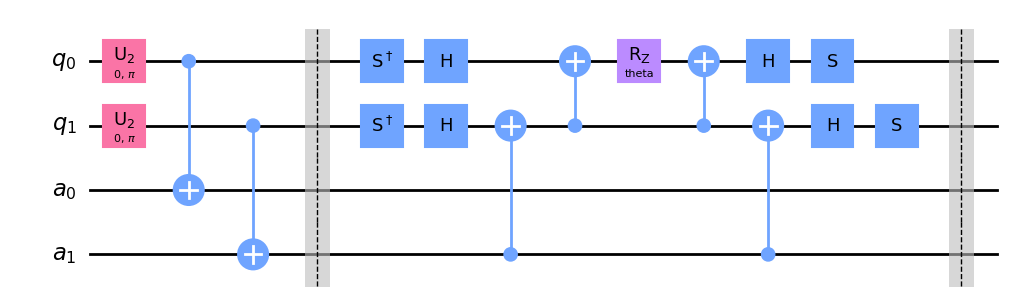

In [72]:
from qiskit.circuit import ParameterExpression
def clean_param_expression(ansatz):
    new_ansatz = ansatz.decompose()
    for d in new_ansatz.data:
        if len(d.operation.params)!=0 and isinstance(d.operation.params[0],ParameterExpression):
            assert len(d)>1 , "This gate contains more than one parameter"
            raw_param = list(d.operation.params[0].parameters)[0]
            print(raw_param)
            d.operation.params = [raw_param]
    return new_ansatz
    

clean_param_expression(ansatz).draw(output="mpl")